### Import necesssary packages

In [47]:
%matplotlib inline
import numpy as np
import random
import glob
import matplotlib
import pylab as pl
from dateutil import parser
import scipy.stats as stats
import datetime


### Create a list of the transcript text file paths

In [48]:
# At work:
TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# Get the file paths to all files of a specified file type from a given directory
def get_files(file_path, file_type):
    file_list = glob.glob(file_path + "*." + file_type)
    return file_list

# Read in all the file paths into a list
TextFiles = get_files(TEXT_PATH,'txt')

# Print first 5 files as an example
TextFiles[:5]

['T:/Quant/TextAnalysis/Transcripts/SP100/Text\\20110719_1_JNJ.txt',
 'T:/Quant/TextAnalysis/Transcripts/SP100/Text\\20100730_1_AEP.txt',
 'T:/Quant/TextAnalysis/Transcripts/SP100/Text\\20100730_1_CVX.txt',
 'T:/Quant/TextAnalysis/Transcripts/SP100/Text\\20100730_1_MET.txt',
 'T:/Quant/TextAnalysis/Transcripts/SP100/Text\\20100730_1_MRK.txt']

### Read stock returns into a dictionary

In [49]:
# process to read in returns into a dictionary: {month_end: {code: (return, market_cap)}}
def get_returns(myFilename):
    returns = {}
    with open(myFilename) as f:
        for line in f:
            code, date, rtn, mcap = line.rstrip('\n').rstrip('\r').split(',')
            if date != 'MthEnd':
                month_end = date[-4:] + date[3:5]
                if month_end not in returns.keys():
                    returns[month_end] = {}
                if rtn != 'NA':
                    rtn = float(rtn)/100
                if mcap != 'NA':
                    mcap = float(mcap)
                returns[month_end][code] = (rtn, mcap)
    return returns

# read in the returns
return_file = LIBRARY_PATH + 'returns_data.csv'
returns = get_returns(return_file)

# print returns 
print (returns)

{'201008': {'AAPL': (0.167215, 222087.1), 'ABBV': ('NA', 'NA'), 'ABT': (0.058776, 76182.4), 'ACN': (0.160929, 25983.5), 'AGN': (-0.017646, 5378.4), 'AIG': (0.15237299999999998, 23682.9), 'ALL': (0.143116, 14850.7), 'AMGN': (0.079741, 48920.5), 'AMZN': (0.258191, 55902.0), 'AXP': (0.054176, 47972.1), 'BA': (0.0885, 44727.7), 'BAC': (0.052361000000000005, 125021.7), 'BIIB': (0.043122999999999995, 14364.6), 'BK': (0.077082, 29452.6), 'BLK': (0.199366, 27185.4), 'BMY': (0.051647, 44723.1), 'BRK/B': (0.049505, 195177.0), 'C': (0.054193, 107462.8), 'CAT': (0.20748899999999998, 41081.6), 'CELG': (0.119293, 23648.1), 'CHTR': (-0.037037, 3795.4), 'CL': (0.040899, 35886.1), 'CMCSA': (0.057619, 47234.0), 'COF': (0.044362000000000006, 17298.0), 'COP': (0.095365, 77772.7), 'COST': (0.14141600000000001, 24811.0), 'CSCO': (0.095822, 114137.4), 'CVS': (0.16641999999999998, 36644.7), 'CVX': (0.09408699999999999, 148944.8), 'DHR': (0.118359, 23709.8), 'DIS': (0.01721, 62236.2), 'DUK': (0.03085, 22655.3)

### Calculate benchmark returns from the stock returns in our universe

In [50]:
# Calculate equal weighted and market cap weighted benchmark returns for our universe
def calculate_benchmark_returns(returns):
    benchmarks = {}
    for date, stocks in returns.items():
        ew_return_sum = 0
        mc_return_sum = 0
        num_stocks = 0
        total_cap = 0
        for code, stock_details in stocks.items():
            rtn, mcap = stock_details
            if rtn != 'NA':
                ew_return_sum += rtn
                num_stocks += 1
            if rtn != 'NA' and mcap != 'NA':
                mc_return_sum += rtn * mcap
                total_cap += mcap
                
            benchmarks[date] = (ew_return_sum / num_stocks, mc_return_sum / total_cap) 

    return benchmarks

# calculate the benchmark returns
benchmarks = calculate_benchmark_returns(returns)

# print the benchmark returns
print (benchmarks)

{'201008': (0.0881136218487395, 0.08558115166669077), '201009': (0.04110199159663863, 0.03912317712576835), '201010': (-0.0012494201680672288, -0.005167079883551803), '201011': (0.0724224333333333, 0.06830077094297442), '201012': (0.020757349999999997, 0.02237254721571953), '201101': (0.03513425833333335, 0.02953707667619748), '201102': (0.0035705785123966937, -0.0034953990567026545), '201103': (0.03489360330578512, 0.028057489998422502), '201104': (-0.007907024793388433, -0.014740056205848766), '201105': (-0.010451024793388431, -0.0144891125134902), '201106': (-0.025120991735537182, -0.011835024388325708), '201107': (-0.059508148760330566, -0.05076915263050178), '201108': (-0.07751888429752063, -0.06049283669337789), '201109': (0.1163942396694215, 0.10053663797345867), '201110': (0.002703909090909089, -0.00030717521357415817), '201111': (0.008007611570247928, 0.016772714063659287), '201112': (0.05313600826446283, 0.04259016626326978), '201201': (0.0408229834710744, 0.04496361189660525

### Create a dummy set of random scores in the preferred score format

The preferred score format is:

`{date: {ticker: score}}`

where

- `date` is `'YYYYMMDD'`

- `ticker` is the string ticker for the stock

- `stock` is a `float()` score if available or 'NA' if not

In [51]:
def get_filename_components(file_path):
    file_path = file_path.split('_')
    date = file_path[0][-8:]
    ticker = file_path[2][:-4]
    score = random.random()
    return (ticker, date, score)

# populate file_details with (ticker, date, score) for each text file
file_details = []
for tf in sorted(TextFiles):
    file_details.append(get_filename_components(tf))

# print the first 5 entries
file_details[:5]


[('AEP', '20100730', 0.3197626120540421),
 ('CVX', '20100730', 0.3813550431870709),
 ('MET', '20100730', 0.2880836010215806),
 ('MRK', '20100730', 0.3560380521428491),
 ('SPG', '20100730', 0.844019820035285)]

In [52]:
# Convert the random file details into preferred score output format: {date: {ticker: score}}
def create_dummy_scores(file_details):
    scores = {}
    for file in file_details:
        (code, date, score) = file
        if date not in scores.keys():
            scores[date] = {}
        scores[date][code] = round(score,4)
    return scores 

# process randomised scores
scores = create_dummy_scores(file_details)

# print all scores in the prefer score output format: {date: {ticker: score}}
print (scores)

{'20100730': {'AEP': 0.3198, 'CVX': 0.3814, 'MET': 0.2881, 'MRK': 0.356, 'SPG': 0.844, 'WY': 0.9174}, '20100803': {'BHI': 0.5924, 'DOW': 0.8614, 'DUK': 0.3164, 'EMR': 0.1609, 'ETR': 0.4876, 'MA': 0.1864, 'NYX': 0.3392, 'PCLN': 0.1389, 'PFE': 0.5523, 'PG': 0.2677}, '20100804': {'CHTR': 0.182, 'DVN': 0.6723, 'FOXA': 0.783, 'TWX': 0.5884}, '20100805': {'AGN': 0.0194, 'ALL': 0.4202, 'MDLZ': 0.7208}, '20100806': {'AIG': 0.5097}, '20100810': {'DIS': 0.6887}, '20100811': {'CSCO': 0.3913}, '20100812': {'GM': 0.7696, 'HSH': 0.9944}, '20100816': {'LOW': 0.7047}, '20100817': {'HD': 0.0482, 'WMT': 0.6031}, '20100818': {'TGT': 0.2384}, '20100819': {'DELL': 0.9597, 'HPQ': 0.1072}, '20100824': {'MDT': 0.1647}, '20100901': {'HNZ': 0.1092}, '20100903': {'CPB': 0.9528}, '20100916': {'FDX': 0.5051, 'ORCL': 0.5115}, '20100923': {'NKE': 0.1378}, '20100928': {'WBA': 0.3018}, '20100930': {'ACN': 0.0051, 'NEE': 0.2188}, '20101006': {'COST': 0.3311, 'MON': 0.2055}, '20101007': {'PEP': 0.062}, '20101012': {'INT

### Convert daily scores to month end scores

In [53]:
# This process converts scores from daily to month end
# It also considers if a score has been updated or not in the month.
# If NOT updated it retains the score from the previous month and increases its age or staleness by 1 month

def collate_month_end_scores(scores):            

    # get all daily days - importantly in sorted chronological order oldest to newest
    dates = sorted(scores.keys())
    # get all month end dates from the daily dates
    month_ends = sorted(list(set([date[:6] for date in dates])))
    # get all stocks in our coverage universe
    codes = []
    for date in dates:
        for code in scores[date].keys():
            if code not in codes:
                codes.append(code)
    # set the current month end to None to start the process
    curr_month_end = None
    # create an empty list to house the month end scores
    monthly_scores = {}

    # pass through the scores in chronological order
    for date in dates:

        # collect the month end for the current date
        month_end = date[:6]

        # if found a new month end
        if month_end != curr_month_end:

            # add a new month end dictionary for the monthly scores dictionary
            monthly_scores[month_end] = {}

            # check if there is a past month
            # if no past month populate the empty dictionary for scores on the given date, i.e. first entry 
            if len(monthly_scores.keys()) < 2: 
                for code, score in scores[date].items():
                    monthly_scores[month_end][code] = (score, 1) # note including a score age parameter

            # otherwise if a past month exists add missing codes for the month either as NA or the previous month value 
            else:

                # check if there is a previous month to grab scores from 
                prev_month_end_idx = month_ends.index(curr_month_end) - 1

                # there is a previous month
                if prev_month_end_idx >= 0:
                    # collect previous month end
                    prev_month_end = month_ends[prev_month_end_idx]
                    # iterate through codes to find ones not in the current month end dictionary
                    for code in codes:
                        if code not in monthly_scores[curr_month_end].keys():
                            if code in monthly_scores[prev_month_end].keys():
                                # there is no previous score
                                if monthly_scores[prev_month_end][code][0] == 'NA':
                                    monthly_scores[curr_month_end][code] = ('NA', 0)
                                # there is a previous score
                                else:
                                    # get the previous score and increment age by one month
                                    (prev_score, age) = monthly_scores[prev_month_end][code]
                                    monthly_scores[curr_month_end][code] = (prev_score, age + 1)                

                # there is not a previous month
                else:
                    # populate missing codes as 'NA'
                    for code in codes:
                        if code not in monthly_scores[curr_month_end].keys():
                            monthly_scores[curr_month_end][code] = ('NA', 0)

            # update the current month end parameter
            curr_month_end = month_end

        # haven't found a new month    
        else:
            for code, score in scores[date].items():
                monthly_scores[month_end][code] = (score, 1) # note including a score age parameter

    return monthly_scores

# collate the month end scores from the daily score data
monthly_scores = collate_month_end_scores(scores)

# print monthly scores
print (monthly_scores)


{'201007': {'AEP': (0.3198, 1), 'CVX': (0.3814, 1), 'MET': (0.2881, 1), 'MRK': (0.356, 1), 'SPG': (0.844, 1), 'WY': (0.9174, 1), 'BHI': ('NA', 0), 'DOW': ('NA', 0), 'DUK': ('NA', 0), 'EMR': ('NA', 0), 'ETR': ('NA', 0), 'MA': ('NA', 0), 'NYX': ('NA', 0), 'PCLN': ('NA', 0), 'PFE': ('NA', 0), 'PG': ('NA', 0), 'CHTR': ('NA', 0), 'DVN': ('NA', 0), 'FOXA': ('NA', 0), 'TWX': ('NA', 0), 'AGN': ('NA', 0), 'ALL': ('NA', 0), 'MDLZ': ('NA', 0), 'AIG': ('NA', 0), 'DIS': ('NA', 0), 'CSCO': ('NA', 0), 'GM': ('NA', 0), 'HSH': ('NA', 0), 'LOW': ('NA', 0), 'HD': ('NA', 0), 'WMT': ('NA', 0), 'TGT': ('NA', 0), 'DELL': ('NA', 0), 'HPQ': ('NA', 0), 'MDT': ('NA', 0), 'HNZ': ('NA', 0), 'CPB': ('NA', 0), 'FDX': ('NA', 0), 'ORCL': ('NA', 0), 'NKE': ('NA', 0), 'WBA': ('NA', 0), 'ACN': ('NA', 0), 'NEE': ('NA', 0), 'COST': ('NA', 0), 'MON': ('NA', 0), 'PEP': ('NA', 0), 'INTC': ('NA', 0), 'JPM': ('NA', 0), 'GOOGL': ('NA', 0), 'GE': ('NA', 0), 'AAPL': ('NA', 0), 'C': ('NA', 0), 'HAL': ('NA', 0), 'IBM': ('NA', 0), 'B

### Calculate portfolios for a given month

In [54]:
# process to calculate the percentile of each of the scores subject to a maximum age of the score
def get_percentile_scores(scores, max_age):
    percentiles = []
    numeric_scores = [score for (score, age) in scores.values() if score != 'NA' and age <= max_age]
    for code in sorted(scores.keys()):
        score, age = scores[code]
        if score == 'NA' or age > max_age:
            percentiles.append('NA')
        else:
            percentiles.append(stats.percentileofscore(numeric_scores, score))
    return percentiles

def convert_to_portfolio_int(percentile, num_portfolios):
    num = num_portfolios * percentile / 100
    if num < 0:
        return 0
    elif num >= num_portfolios:
        return num_portfolios - 1
    else:
        return int(num)

def create_fractile_portfolios(scores, num_portfolios, max_age):
    percentiles = get_percentile_scores(scores, max_age)
    # populate holdings dictionary for selected number of portfolios
    holdings = {i:[] for i in range(0,num_portfolios)}
    holdings['NA'] = []
    for code, percentile in zip(sorted(scores.keys()), percentiles):
        if percentile == 'NA':
            holdings['NA'].append(code)
        else:
            port_num = convert_to_portfolio_int(percentile, num_portfolios)
            holdings[port_num].append(code)
    return holdings


In [55]:
# create a test month score set
test_month = monthly_scores['201107']
print (test_month)

{'C': (0.0773, 1), 'HAL': (0.313, 1), 'IBM': (0.6204, 1), 'AAPL': (0.439, 1), 'BAC': (0.3603, 1), 'BK': (0.0942, 1), 'GS': (0.7878, 1), 'JNJ': (0.5564, 1), 'KO': (0.8975, 1), 'UNH': (0.3387, 1), 'WFC': (0.7382, 1), 'ABT': (0.9501, 1), 'AXP': (0.7658, 1), 'BLK': (0.0599, 1), 'EMC': (0.2885, 1), 'INTC': (0.0822, 1), 'MO': (0.9439, 1), 'QCOM': (0.9003, 1), 'USB': (0.6867, 1), 'UTX': (0.8993, 1), 'BAX': (0.3481, 1), 'DHR': (0.4747, 1), 'FCX': (0.4903, 1), 'KMI': (0.2495, 1), 'LLY': (0.8084, 1), 'MS': (0.2546, 1), 'MSFT': (0.3025, 1), 'PEP': (0.2217, 1), 'PM': (0.3114, 1), 'T': (0.272, 1), 'UNP': (0.5169, 1), 'CAT': (0.0458, 1), 'GE': (0.5931, 1), 'HON': (0.342, 1), 'MCD': (0.2572, 1), 'SLB': (0.2369, 1), 'VZ': (0.4149, 1), 'XRX': (0.8277, 1), 'BHI': (0.6747, 1), 'TXN': (0.5161, 1), 'AGN': (0.8224, 1), 'AMZN': (0.0241, 1), 'BIIB': (0.6803, 1), 'F': (0.092, 1), 'GILD': (0.925, 1), 'LMT': (0.0095, 1), 'MMM': (0.2787, 1), 'NOV': (0.4484, 1), 'NSC': (0.9103, 1), 'OXY': (0.0414, 1), 'RF': (0.629

In [56]:
# calculate the percentiles for the score in the test month
percentiles = get_percentile_scores(test_month, 4)
print (percentiles)


[22.429906542056074, 'NA', 43.925233644859816, 'NA', 99.065420560747668, 86.915887850467286, 58.878504672897193, 88.785046728971963, 14.018691588785046, 85.046728971962608, 71.962616822429908, 4.6728971962616823, 69.158878504672899, 83.177570093457945, 42.990654205607477, 39.252336448598129, 38.31775700934579, 74.766355140186917, 75.700934579439249, 13.084112149532709, 8.4112149532710276, 20.5607476635514, 9.3457943925233646, 7.4766355140186906, 3.7383177570093453, 'NA', 1.8691588785046727, 57.943925233644855, 71.028037383177562, 47.663551401869157, 57.009345794392516, 17.75700934579439, 72.89719626168224, 54.205607476635507, 67.289719626168221, 91.588785046728972, 40.186915887850468, 48.598130841121495, 65.420560747663544, 62.616822429906534, 'NA', 45.794392523364486, 31.775700934579437, 'NA', 'NA', 81.308411214953267, 12.149532710280374, 'NA', 49.532710280373834, 68.224299065420553, 19.626168224299064, 55.140186915887845, 59.813084112149525, 97.196261682242991, 70.09345794392523, 61.

In [57]:
# test the fractile portfolio creator for the test month
test_portfolios = create_fractile_portfolios(test_month, num_portfolios=5, max_age=4)
print (test_portfolios)

{0: ['AIG', 'AMZN', 'BK', 'BLK', 'C', 'CAT', 'CELG', 'CL', 'CPB', 'F', 'FOXA', 'HD', 'INTC', 'LMT', 'MET', 'OXY', 'PCLN', 'PG', 'RTN', 'UPS', 'V'], 1: ['0848680D', 'BAC', 'BAX', 'BMY', 'EMC', 'HAL', 'HON', 'KMI', 'MCD', 'MMM', 'MS', 'MSFT', 'NEE', 'ORCL', 'PEP', 'PM', 'SLB', 'SPG', 'T', 'TWX', 'UNH'], 2: ['AAPL', 'AEP', 'BA', 'CMCSA', 'COP', 'COST', 'CVS', 'DELL', 'DHR', 'DVN', 'FCX', 'GD', 'GE', 'JNJ', 'MDLZ', 'NOV', 'SBUX', 'SO', 'TGT', 'TXN', 'UNP', 'VZ'], 3: ['AMGN', 'AVP', 'BHI', 'BIIB', 'COF', 'CSCO', 'CVX', 'DIS', 'DOW', 'FDX', 'GM', 'GOOGL', 'HPQ', 'IBM', 'LOW', 'MDT', 'MRK', 'RF', 'USB', 'WFC', 'WMT'], 4: ['ABT', 'ACN', 'AGN', 'ALL', 'AXP', 'DD', 'EXC', 'GILD', 'GS', 'HSH', 'JPM', 'KO', 'LLY', 'MO', 'MON', 'NSC', 'QCOM', 'UTX', 'WMB', 'WY', 'XOM', 'XRX'], 'NA': ['AA', 'ABBV', 'CHTR', 'DUK', 'EMR', 'ETR', 'FB', 'HNZ', 'KHC', 'MA', 'NKE', 'NYX', 'PFE', 'PYPL', 'WBA']}


In [58]:
# test for all month_ends 

# get key dates
dates = sorted(scores.keys())                                 # important in chronological order
month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

monthly_portfolios = {}
for month_end in month_ends:
    monthly_portfolios[month_end] = create_fractile_portfolios(monthly_scores[month_end], num_portfolios=5, max_age=4)
    print (month_end, [(port, len(codes)) for port, codes in monthly_portfolios[month_end].items()])
    

201007 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), ('NA', 116)]
201008 [(0, 4), (1, 5), (2, 5), (3, 5), (4, 6), ('NA', 97)]
201009 [(0, 6), (1, 6), (2, 7), (3, 6), (4, 7), ('NA', 90)]
201010 [(0, 20), (1, 21), (2, 21), (3, 21), (4, 21), ('NA', 18)]
201011 [(0, 22), (1, 22), (2, 23), (3, 22), (4, 23), ('NA', 10)]
201012 [(0, 22), (1, 22), (2, 23), (3, 22), (4, 23), ('NA', 10)]
201101 [(0, 22), (1, 23), (2, 22), (3, 23), (4, 23), ('NA', 9)]
201102 [(0, 22), (1, 22), (2, 23), (3, 22), (4, 23), ('NA', 10)]
201103 [(0, 21), (1, 22), (2, 22), (3, 22), (4, 23), ('NA', 12)]
201104 [(0, 22), (1, 23), (2, 22), (3, 23), (4, 23), ('NA', 9)]
201105 [(0, 22), (1, 23), (2, 22), (3, 23), (4, 23), ('NA', 9)]
201106 [(0, 21), (1, 22), (2, 22), (3, 22), (4, 22), ('NA', 13)]
201107 [(0, 21), (1, 21), (2, 22), (3, 21), (4, 22), ('NA', 15)]
201108 [(0, 22), (1, 22), (2, 22), (3, 22), (4, 23), ('NA', 11)]
201109 [(0, 22), (1, 22), (2, 22), (3, 22), (4, 23), ('NA', 11)]
201110 [(0, 22), (1, 23), (2, 22), (3, 23)

As you can see there is enough data for portfolio return reporting from scores at the end of October 2010, i.e. 201010, through to the end of October 2017, i.e. using scores at the end of September 2017 to produce portfolios held in October 2017. Accordingly, our back-test window maximum is 30 September 2010 to 31 October 2017 or 7 years and one month.

### Calculate portfolio alphas for a given month and benchmark type

We can test against an equal-weighted (bm_type=0) or market-cap weighted (bm_type=1) benchmark.

We are forming equal-weighted portfolios, so using an equal-weighted benchmark probably makes most sense.

In [59]:
def average_return(returns, benchmark):
    if len(returns) == 0:
        average_alpha = 0
    else:
        average_alpha = sum(returns)/len(returns) - benchmark
    return (average_alpha, len(returns))

def calculate_portfolio_returns(portfolios, returns, benchmark, bm_type=0):
    portfolio_returns = {portfolio:[] for portfolio in portfolios.keys()}
    for portfolio, stocks in portfolios.items():
        if portfolio != 'NA':
            for stock in stocks:
                if stock in returns.keys():
                    if returns[stock][0] != 'NA':
                        portfolio_returns[portfolio].append(returns[stock][0])
        else:
            for stock in stocks:
                portfolio_returns['NA'].append(benchmark[bm_type])
    
    portfolio_returns = {pf:average_return(rets, benchmark[bm_type]) for pf, rets in portfolio_returns.items()}
    
    return portfolio_returns
                    

In [60]:
test_portfolio_returns = calculate_portfolio_returns(monthly_portfolios['201110'], returns['201110'], benchmarks['201110'])
print (test_portfolio_returns)

{0: (-0.0016114090909090846, 22), 1: (-0.024231648221343872, 23), 2: (0.012687454545454549, 22), 3: (0.007295743083003955, 23), 4: (0.008046438735177866, 23), 'NA': (4.336808689942018e-19, 9)}


### Calculate portfolio returns time series

In [61]:
# This process produces a time series of monthly portfolio returns by iterating through the whole scores dictionary
def portfolio_return_time_series(scores, returns, benchmarks, num_portfolios=5, max_age=4):
    monthly_portfolios = {}
    portfolio_return_time_series = {}

    # get key dates
    dates = sorted(scores.keys())                                 # important in chronological order
    month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

    for month_end in month_ends[1:-1]:
        monthly_portfolios[month_end] = create_fractile_portfolios(monthly_scores[month_end], num_portfolios, max_age)
        portfolio_return_time_series[month_end] = calculate_portfolio_returns(monthly_portfolios[month_end], returns[month_end], benchmarks[month_end])
    return portfolio_return_time_series

        

In [62]:
# Check that we have all the returns keys that we need
[key for key in monthly_portfolios.keys() if key not in returns.keys()]


['201007', '201710']

This shows that we don't have month forward returns for portfolios created at the end of July 2010 and October 2017, we don't need these based on our data range as shown above previously

In [63]:
# create the returns time series 
time_series = portfolio_return_time_series(monthly_portfolios, returns, benchmarks)
print (time_series)

{'201008': {0: (-0.0167973718487395, 4), 1: (-0.0661308218487395, 5), 2: (0.013435578151260508, 5), 3: (-0.027759221848739503, 5), 4: (-0.0653472218487395, 5), 'NA': (0.0, 97)}, '201009': {0: (-0.005714158263305298, 6), 1: (-0.02828482492997196, 6), 2: (-0.01075470588235292, 7), 3: (-0.011665658263305304, 6), 4: (0.020900175070028032, 6), 'NA': (1.0408340855860843e-16, 90)}, '201010': {0: (0.0060244201680672285, 20), 1: (0.008186563025210081, 21), 2: (-0.021579960784313727, 21), 3: (-0.003005479831932772, 20), 4: (0.0010670868347338958, 21), 'NA': (4.336808689942018e-19, 18)}, '201011': {0: (-0.0069423424242423815, 22), 1: (-0.006526842424242396, 22), 2: (0.04791352318840582, 23), 3: (-0.013196342424242377, 22), 4: (-0.027281389855072426, 23), 'NA': (0.0, 10)}, '201012': {0: (-0.006694713636363632, 22), 1: (0.0058368318181818216, 22), 2: (0.005485867391304355, 23), 3: (-0.007386622727272725, 22), 4: (-0.008512219565217386, 23), 'NA': (3.469446951953614e-18, 10)}, '201101': {0: (-0.0096

### Construct cumulative alpha time series

In [64]:
def calculate_cumulative_alpha(time_series, dates):
    port_nums = [num for num in time_series[list(time_series.keys())[0]].keys() if num != 'NA']
    cumulative_portfolios = {i:[] for i in port_nums}
    cumulative_alphas = []
    for date in dates:
        return_series = time_series[date]
        for port_num in port_nums:
            cumulative_portfolios[port_num].append(return_series[port_num][0])
    for portfolio in sorted(cumulative_portfolios.keys()):
        cumulative_alphas.append([sum(cumulative_portfolios[portfolio][:i]) for i in range(len(cumulative_portfolios[portfolio]))])
    return cumulative_alphas


def calculate_portfolio_holding_numbers(time_series, dates):
    port_nums = [num for num in time_series[list(time_series.keys())[0]].keys() if num != 'NA']
    portfolio_holdings = {i:[] for i in port_nums}
    holdings = []
    for date in dates:
        return_series = time_series[date]
        for port_num in port_nums:
            portfolio_holdings[port_num].append(return_series[port_num][1])
    for portfolio in sorted(portfolio_holdings.keys()):
        holdings.append(portfolio_holdings[portfolio])
    return holdings

In [65]:
cumulative_alphas = calculate_cumulative_alpha(time_series, month_ends[1:-1])
print (cumulative_alphas)

[[0, -0.0167973718487395, -0.0225115301120448, -0.01648710994397757, -0.02342945236821995, -0.030124166004583584, -0.039736515247007845, -0.046994548304859086, -0.036994389705882307, -0.019118592185221148, -0.012318249210014535, -0.010063971760191642, -0.0014805372855753642, 0.009793983375581636, 0.011126061887978317, 0.009514652797069232, 0.008723132135912214, 0.006091790538116058, -0.002759147478412889, -0.011767862354445942, -0.007959610288330237, -0.01222272185857817, -0.024632030353362092, -0.02990006548216771, -0.03933128306786071, -0.03836860646577428, -0.043271581485290284, -0.01750072231986554, -0.037075545895197314, -0.031964596998565485, -0.04262286064548767, -0.03433122280365468, -0.050562359853596604, -0.04044198476120932, -0.04483462112484569, -0.039564281101232966, -0.03039652077065446, -0.05234228346250808, -0.05379344678403501, -0.04831248697402405, -0.05908207291749236, -0.06923158514056338, -0.0626849514507238, -0.061340438081739834, -0.06571784565749741, -0.04804182

In [66]:
holdings = calculate_portfolio_holding_numbers(time_series, month_ends[1:-1])
print (holdings)

[[4, 6, 20, 22, 22, 22, 22, 21, 22, 22, 21, 21, 22, 22, 22, 22, 21, 22, 22, 22, 22, 22, 21, 22, 22, 21, 22, 21, 21, 21, 22, 21, 22, 22, 21, 22, 21, 21, 23, 22, 22, 22, 22, 22, 22, 22, 21, 22, 21, 21, 21, 22, 21, 21, 22, 22, 22, 22, 21, 21, 22, 21, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 20, 21, 21, 21, 21, 22, 21, 21, 21, 19, 20, 21, 21], [5, 6, 21, 22, 22, 23, 22, 22, 23, 23, 22, 21, 22, 22, 23, 22, 22, 22, 23, 23, 23, 22, 22, 23, 23, 21, 22, 22, 21, 22, 22, 22, 23, 23, 22, 23, 22, 20, 22, 22, 23, 23, 22, 22, 23, 22, 22, 23, 21, 22, 22, 22, 21, 21, 22, 22, 22, 22, 21, 22, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 22, 22, 22, 21, 22, 22, 22, 22, 22, 22, 22, 22, 21, 22, 21, 21], [5, 7, 21, 23, 23, 22, 23, 22, 22, 22, 22, 22, 22, 22, 22, 23, 21, 22, 23, 22, 23, 23, 22, 22, 22, 22, 22, 22, 21, 22, 23, 22, 23, 23, 21, 22, 22, 22, 23, 23, 23, 23, 23, 22, 22, 22, 21, 23, 23, 21, 23, 22, 21, 21, 22, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 22, 21, 22, 22, 21, 22, 22, 21, 22, 

### Print the time series of portfolio data

In [67]:
def convert_YYYYMM(date):
    year = int(date[:4])
    month = int(date[4:])
    day = 1
    return datetime.datetime(year=year, month=month, day=day)

def print_time_series(time_series, dates):
    dates = [convert_YYYYMM(date) for date in dates]
    for series in time_series:
        pl.plot(dates, series)
    pl.show()

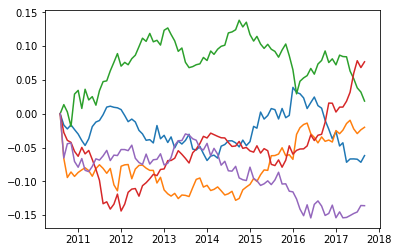

In [68]:
print_time_series(cumulative_alphas, month_ends[1:-1])

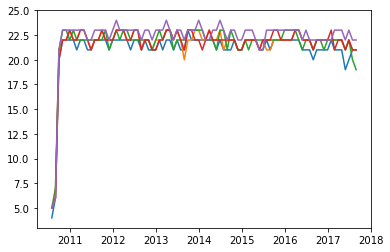

In [69]:
print_time_series(holdings, month_ends[1:-1])

### Combined portfolio return calculator

The procedure combines all of the above into one function, which we just need to supply the scores to produce the portfolio returns

In [70]:
def produce_portfolio_results(scores, LIBRARY_PATH, num_portfolios=5, max_age=4):
    
    # Get returns
    returns = get_returns(LIBRARY_PATH + 'returns_data.csv')

    # Calculate the benchmark returns
    benchmarks = calculate_benchmark_returns(returns)
    
    # Collate the month end scores from the daily score data
    monthly_scores = collate_month_end_scores(scores)
    
    # Get all daily dates from score and convert to month ends
    dates = sorted(scores.keys())                                 # important in chronological order
    month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

    # Create month end portfolios
    monthly_portfolios = {}
    for month_end in month_ends:
        monthly_portfolios[month_end] = create_fractile_portfolios(monthly_scores[month_end], num_portfolios, max_age)

    # Calculate monthly returns time series
    monthly_returns_time_series = portfolio_return_time_series(monthly_portfolios, returns, benchmarks)
    
    # Calculate cumulative alpha and portfolio holding numbers time series
    month_ends = sorted(returns.keys())                           # important in chronological order
    cumulative_alphas = calculate_cumulative_alpha(monthly_returns_time_series, month_ends)
    holdings = calculate_portfolio_holding_numbers(monthly_returns_time_series, month_ends)
    
    # Print cumulative alpha and portfolio holding numbers
    print_time_series(cumulative_alphas, month_ends)
    print_time_series(holdings, month_ends)
    

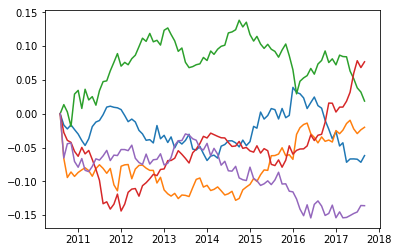

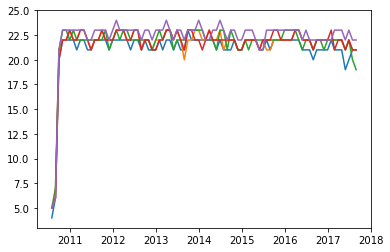

In [71]:
produce_portfolio_results(scores, LIBRARY_PATH)

In [72]:
import portfolio_calculator

In [73]:
portfolio_calculator.produce_portfolio_results(scores, LIBRARY_PATH)

NameError: name 'stats' is not defined